Connected to tf (Python 3.11.14)

In [ ]:
""" FlowNet model written in TF2/Keras
    https://arxiv.org/pdf/1504.06852.pdf
"""

from typing import Dict, Tuple, Optional, Union
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

import utils_io as uio
import utils
from config import CONFIG_FLOWNET, CONFIG_TRAINING


class MalformedNetworkType(Exception):
    """The provided network type doesn't match one of 'simple' or 'correlation'."""


class FlowNet:
    """ FlowNetSimple model from the Computer Vision Group of Freiburg.
        https://lmb.informatik.uni-freiburg.de/
        https://lmb.informatik.uni-freiburg.de/Publications/2015/DFIB15/flownet.pdf
    """

    def __init__(self, config: Dict):
        self.config = config

        self.model = self._construct_network(config)

    def __getattr__(self, attr):
        """ Rather than potentially override any of the tf.keras.Model methods by subclassing and defining new methods,
            create a composition class with self.model:tf.keras.Model and allow attribute calls directly against self.model
        """
        return getattr(self.model, attr)

    @staticmethod
    def get_simple_model(config: Dict) -> tf.keras.Model:
        inputs = tf.keras.Input(shape=(384, 512, 6))

        conv_1 = tf.keras.layers.Conv2D(32, 7, strides=2, padding='same', activation='relu', name='conv1')(inputs)
        conv_2 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu', name='conv2')(conv_1)
        conv_3 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='same', activation='relu', name='conv3')(conv_2)

        predict_3 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_3')(conv_3)

        upconv_2 = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu', name='upconv_2')(conv_3)
        flow_3 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_3')(predict_3)
        concat_2 = tf.keras.layers.Concatenate(axis=-1, name='concat_2')([upconv_2, conv_2, flow_3])
        predict_2 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_2')(concat_2)

        upconv_1 = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu', name='upconv_1')(concat_2)
        flow_2 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_2')(predict_2)
        concat_1 = tf.keras.layers.Concatenate(axis=-1, name='concat_1')([upconv_1, conv_1, flow_2])
        predict_1 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_1')(concat_1)

        if config['training']:
            return tf.keras.Model(inputs=inputs, outputs=[predict_3, predict_2, predict_1])

        return tf.keras.Model(inputs=inputs, outputs=predict_1)


    def disable_training(self):
        """ After training is finished, run this method to have self.model predict a single array rather than a list of 6 arrays
        """
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=self.model.layers[-1].output)

    def enable_training(self):
        """ If you need to re-enable training, run this method to have self.model predict the list of 6 predictions
        """
        output_layers = [layer.output for layer in self.model.layers if 'predict' in layer.name]
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=output_layers)

    @staticmethod
    def get_corr_model(config: Dict) -> tf.keras.Model:
        raise NotImplementedError("The correlation model hasn't been implemented.")

    @staticmethod
    def _construct_network(config: Dict) -> tf.keras.Model:
        if config['architecture'] == 'simple':
            return FlowNet.get_simple_model(config)
        if config['architecture'] == 'corr':
            return FlowNet.get_corr_model(config)

        raise MalformedNetworkType(f"{config['architecture']}: {MalformedNetworkType.__doc__}")


class DataGenerator:
    """ Instantiate then call instance.next_train() to get a generator for training images/labels
            call instance.next_val() to get a generator for validation images/labels
    """

    def __init__(self,
                 network_type: str,
                 flo_normalization: Tuple[float, float],
                 root_path: Path,
                 batch_size: int,
                 validation_batch_size: int,
                 train_ratio: Union[float, int] = 1,
                 test_ratio: Union[float, int] = 0,
                 shuffle: bool = False,
                 augmentations: Optional[Dict] = None):
        self.network_type = network_type

        images = list(root_path.glob('*1.ppm'))
        self.train, self.val, self.test = utils.get_train_val_test(images, train_ratio, test_ratio, shuffle)
        self.batch_size = batch_size
        self.validation_batch_size = validation_batch_size
        self.replace = True
        self.flo_normalization = flo_normalization
        self.augmentations = augmentations
        
    def next_train(self):

        while True:
            images = np.random.choice(self.train, self.batch_size, replace=self.replace)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if not self.augmentations is None:
                img1, img2, label = self._augment(img1, img2, label)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def next_val(self):

        while True:
            images = np.random.choice(self.val, self.validation_batch_size, replace=False)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def _augment(self, img1, img2, label):
        # Augmentations are more awkward because of the Siamese architecture, I can't justify applying different color transforms to each image independently
        # I'm 100 certain there is a better way to do this as this is extremely inefficient with each call likely containing some portion of each other call.
        r = np.random.rand(len(self.augmentations))
        r_inc = 0  # This, with r, are used to randomly turn on/off augmentations so that not every augmentation is applied each time
        r_onoff = 2/5
        if 'brightness' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['brightness']
            def brt(x, idx): return tf.image.adjust_brightness(x, rdm[idx])
            img1 = tf.stack([brt(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([brt(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'multiplicative_colour' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size, 3) * (self.augmentations['multiplicative_colour'][1] -
                                                        self.augmentations['multiplicative_colour'][0]) + self.augmentations['multiplicative_colour'][0]

            def mc(x, idx): return x * rdm[idx]
            img1 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1
        if 'gamma' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['gamma'][1] - self.augmentations['gamma'][0]) + self.augmentations['gamma'][0]
            def gam(x, idx): return tf.image.adjust_gamma(x, gamma=rdm[idx])
            img1 = tf.stack([gam(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([gam(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'contrast' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['contrast'][1] - self.augmentations['contrast'][0]) + self.augmentations['contrast'][0]
            def cts(x, idx): return tf.image.adjust_contrast(x, contrast_factor=rdm[idx])
            img1 = tf.stack([cts(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([cts(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'gaussian_noise' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['gaussian_noise']
            def gau(x, idx): return x + tf.random.normal(x.shape, mean=0.0, stddev=rdm[idx], dtype=x.dtype)
            img1 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1

        return img1, img2, label


class EndPointError(tf.keras.losses.Loss):
    """ EndPointError is the Euclidean distance between the predicted flow vector and the ground truth averaged over all pixels.
        The resizing is required because the loss is calculated for each flow prediction which occur at different stride levels,
        resizing effectively averages at that scale.
    """

    def call(self, y_true, y_pred):
        return K.sqrt(K.sum(K.square(tf.image.resize(y_true, y_pred.shape[1:3]) - y_pred), axis=1, keepdims=True))
    

def load_images(image_name: str):
    """ Debug function to load the first image for visualization
    """
    root_path = Path(r'/Users/oscar/Downloads/FlyingChairs_release/data')
    flo_path = root_path / f'{image_name}_flow.flo'
    img1_path = root_path / f'{image_name}_img1.ppm'
    img2_path = root_path / f'{image_name}_img2.ppm'
    flo = uio.read(str(flo_path))
    img1 = uio.read(str(img1_path))
    img2 = uio.read(str(img2_path))
    img = np.expand_dims(np.concatenate([img1, img2], axis=-1), axis=0)

    # fig, ax = plt.subplots(ncols=2, nrows=2)
    # ax[0,0].imshow(img1)
    # ax[0,1].imshow(img2)
    # ax[1,0].imshow(flo[...,0])
    # ax[1,1].imshow(flo[...,1])
    # plt.show()

    return img, np.expand_dims(flo, axis=0)


def show_images(simple_images, label):
    """
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=2, nrows=2)
    ax[0, 0].imshow(simple_images[..., :3])
    ax[0, 1].imshow(simple_images[..., 3:])
    ax[1, 0].imshow(label[..., 0])
    ax[1, 1].imshow(label[..., 1])
    plt.show()


def main():
    config_network = deepcopy(CONFIG_FLOWNET)
    config_training = deepcopy(CONFIG_TRAINING)

    # On first run, populate the min, max scaling values for the flo dataset
    # min, max = utils.get_training_min_max(config_training['img_path'])

    flownet = FlowNet(config_network)

    loss = EndPointError()

    flownet.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=[loss, loss, loss, loss, loss, loss],
                    loss_weights=config_training['loss_weights'][::-1])

    data_generator = DataGenerator(config_network['architecture'],
                                   config_network['flo_normalization'],
                                   config_training['img_path'],
                                   config_training['batch_size'],
                                   config_training['validation_batch_size'],
                                   config_training['train_ratio'],
                                   config_training['test_ratio'],
                                   config_training['shuffle'],
                                   config_training['augmentations'])

    log_dir = f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_filepath = f"checkpoint/{datetime.now().strftime('%Y%m%d-%H%M%S')}.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                   save_weights_only=False,
                                                                   monitor='val_loss',
                                                                   mode='min',
                                                                   save_best_only=True)

    # if not config_training['pretrained_path'] is None:
    #     # flownet.model = tf.keras.models.load_model(config_training['pretrained_path'], custom_objects={'EndPointError': EndPointError})
    # flownet.fit(x=data_generator.next_train(),
    #             epochs=1,
    #             verbose=1,
    #             steps_per_epoch=200 // config_training['batch_size'],
    #             validation_data=data_generator.next_val(),
    #             validation_steps=4,
    #             validation_batch_size=config_training['validation_batch_size'],
    #             callbacks=[tensorboard_callback, model_checkpoint_callback],
    #             # use_multiprocessing=True
    #             )
    flownet.load_weights("/Users/oscar/Etudes/Ecole/PR/FlowNet_v1_TF2-master/src/flow.weights.h5")
    # flownet.save_weights('flow.weights.h5')
    # flownet.disable_training()

    # #
    # Temporary debugging and visualization
    # #
    # img, flo = load_images(image_name="20000")
    # norm_img = utils.normalize_images(img)
    # predicted_flo = flownet.predict(norm_img)
    # predicted_flo = utils.denormalize_flo(predicted_flo, config_network['flo_normalization'])
    # predicted_flo = tf.image.resize(predicted_flo, (384, 512)).numpy()

    # import matplotlib.pyplot as plt
    # scale_min = np.min([np.min(flo), np.min(predicted_flo)])
    # scale_max = np.max([np.max(flo), np.max(predicted_flo)])
    # fig, ax = plt.subplots(ncols=2, nrows=3)
    # ax[0, 0].imshow(img[0, ..., :3])
    # ax[0, 1].imshow(img[0, ..., 3:])
    # ax[0, 0].set_ylabel('Input images')
    # ax[1, 0].imshow(flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[1, 1].imshow(flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[1, 0].set_ylabel('Ground truth flows')
    # ax[2, 0].imshow(predicted_flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[2, 1].imshow(predicted_flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[2, 0].set_ylabel('Predicted flows')
    # plt.show()

    # # print('stall')


import matplotlib.pyplot as plt

# prediction shape: [1, H, W, 2]
flow = flownet.predict(images)[0]

flow_img = flow_to_color(flow)

plt.figure(figsize=(6, 4))
plt.imshow(flow_img)
plt.axis("off")
plt.title("Optical Flow (Middlebury)")
plt.show()

    



if __name__ == "__main__":
    main()

NameError: name 'flownet' is not defined

In [ ]:
""" FlowNet model written in TF2/Keras
    https://arxiv.org/pdf/1504.06852.pdf
"""

from typing import Dict, Tuple, Optional, Union
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

import utils_io as uio
import utils
from config import CONFIG_FLOWNET, CONFIG_TRAINING
import matplotlib.pyplot as plt


class MalformedNetworkType(Exception):
    """The provided network type doesn't match one of 'simple' or 'correlation'."""


class FlowNet:
    """ FlowNetSimple model from the Computer Vision Group of Freiburg.
        https://lmb.informatik.uni-freiburg.de/
        https://lmb.informatik.uni-freiburg.de/Publications/2015/DFIB15/flownet.pdf
    """

    def __init__(self, config: Dict):
        self.config = config

        self.model = self._construct_network(config)

    def __getattr__(self, attr):
        """ Rather than potentially override any of the tf.keras.Model methods by subclassing and defining new methods,
            create a composition class with self.model:tf.keras.Model and allow attribute calls directly against self.model
        """
        return getattr(self.model, attr)

    @staticmethod
    def get_simple_model(config: Dict) -> tf.keras.Model:
        inputs = tf.keras.Input(shape=(384, 512, 6))

        conv_1 = tf.keras.layers.Conv2D(32, 7, strides=2, padding='same', activation='relu', name='conv1')(inputs)
        conv_2 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu', name='conv2')(conv_1)
        conv_3 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='same', activation='relu', name='conv3')(conv_2)

        predict_3 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_3')(conv_3)

        upconv_2 = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu', name='upconv_2')(conv_3)
        flow_3 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_3')(predict_3)
        concat_2 = tf.keras.layers.Concatenate(axis=-1, name='concat_2')([upconv_2, conv_2, flow_3])
        predict_2 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_2')(concat_2)

        upconv_1 = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu', name='upconv_1')(concat_2)
        flow_2 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_2')(predict_2)
        concat_1 = tf.keras.layers.Concatenate(axis=-1, name='concat_1')([upconv_1, conv_1, flow_2])
        predict_1 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_1')(concat_1)

        if config['training']:
            return tf.keras.Model(inputs=inputs, outputs=[predict_3, predict_2, predict_1])

        return tf.keras.Model(inputs=inputs, outputs=predict_1)


    def disable_training(self):
        """ After training is finished, run this method to have self.model predict a single array rather than a list of 6 arrays
        """
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=self.model.layers[-1].output)

    def enable_training(self):
        """ If you need to re-enable training, run this method to have self.model predict the list of 6 predictions
        """
        output_layers = [layer.output for layer in self.model.layers if 'predict' in layer.name]
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=output_layers)

    @staticmethod
    def get_corr_model(config: Dict) -> tf.keras.Model:
        raise NotImplementedError("The correlation model hasn't been implemented.")

    @staticmethod
    def _construct_network(config: Dict) -> tf.keras.Model:
        if config['architecture'] == 'simple':
            return FlowNet.get_simple_model(config)
        if config['architecture'] == 'corr':
            return FlowNet.get_corr_model(config)

        raise MalformedNetworkType(f"{config['architecture']}: {MalformedNetworkType.__doc__}")


class DataGenerator:
    """ Instantiate then call instance.next_train() to get a generator for training images/labels
            call instance.next_val() to get a generator for validation images/labels
    """

    def __init__(self,
                 network_type: str,
                 flo_normalization: Tuple[float, float],
                 root_path: Path,
                 batch_size: int,
                 validation_batch_size: int,
                 train_ratio: Union[float, int] = 1,
                 test_ratio: Union[float, int] = 0,
                 shuffle: bool = False,
                 augmentations: Optional[Dict] = None):
        self.network_type = network_type

        images = list(root_path.glob('*1.ppm'))
        self.train, self.val, self.test = utils.get_train_val_test(images, train_ratio, test_ratio, shuffle)
        self.batch_size = batch_size
        self.validation_batch_size = validation_batch_size
        self.replace = True
        self.flo_normalization = flo_normalization
        self.augmentations = augmentations
        
    def next_train(self):

        while True:
            images = np.random.choice(self.train, self.batch_size, replace=self.replace)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if not self.augmentations is None:
                img1, img2, label = self._augment(img1, img2, label)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def next_val(self):

        while True:
            images = np.random.choice(self.val, self.validation_batch_size, replace=False)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def _augment(self, img1, img2, label):
        # Augmentations are more awkward because of the Siamese architecture, I can't justify applying different color transforms to each image independently
        # I'm 100 certain there is a better way to do this as this is extremely inefficient with each call likely containing some portion of each other call.
        r = np.random.rand(len(self.augmentations))
        r_inc = 0  # This, with r, are used to randomly turn on/off augmentations so that not every augmentation is applied each time
        r_onoff = 2/5
        if 'brightness' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['brightness']
            def brt(x, idx): return tf.image.adjust_brightness(x, rdm[idx])
            img1 = tf.stack([brt(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([brt(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'multiplicative_colour' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size, 3) * (self.augmentations['multiplicative_colour'][1] -
                                                        self.augmentations['multiplicative_colour'][0]) + self.augmentations['multiplicative_colour'][0]

            def mc(x, idx): return x * rdm[idx]
            img1 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1
        if 'gamma' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['gamma'][1] - self.augmentations['gamma'][0]) + self.augmentations['gamma'][0]
            def gam(x, idx): return tf.image.adjust_gamma(x, gamma=rdm[idx])
            img1 = tf.stack([gam(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([gam(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'contrast' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['contrast'][1] - self.augmentations['contrast'][0]) + self.augmentations['contrast'][0]
            def cts(x, idx): return tf.image.adjust_contrast(x, contrast_factor=rdm[idx])
            img1 = tf.stack([cts(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([cts(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'gaussian_noise' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['gaussian_noise']
            def gau(x, idx): return x + tf.random.normal(x.shape, mean=0.0, stddev=rdm[idx], dtype=x.dtype)
            img1 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1

        return img1, img2, label


class EndPointError(tf.keras.losses.Loss):
    """ EndPointError is the Euclidean distance between the predicted flow vector and the ground truth averaged over all pixels.
        The resizing is required because the loss is calculated for each flow prediction which occur at different stride levels,
        resizing effectively averages at that scale.
    """

    def call(self, y_true, y_pred):
        return K.sqrt(K.sum(K.square(tf.image.resize(y_true, y_pred.shape[1:3]) - y_pred), axis=1, keepdims=True))
    

def load_images(image_name: str):
    """ Debug function to load the first image for visualization
    """
    root_path = Path(r'/Users/oscar/Downloads/FlyingChairs_release/data')
    flo_path = root_path / f'{image_name}_flow.flo'
    img1_path = root_path / f'{image_name}_img1.ppm'
    img2_path = root_path / f'{image_name}_img2.ppm'
    flo = uio.read(str(flo_path))
    img1 = uio.read(str(img1_path))
    img2 = uio.read(str(img2_path))
    img = np.expand_dims(np.concatenate([img1, img2], axis=-1), axis=0)

    # fig, ax = plt.subplots(ncols=2, nrows=2)
    # ax[0,0].imshow(img1)
    # ax[0,1].imshow(img2)
    # ax[1,0].imshow(flo[...,0])
    # ax[1,1].imshow(flo[...,1])
    # plt.show()

    return img, np.expand_dims(flo, axis=0)


def show_images(simple_images, label):
    """
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=2, nrows=2)
    ax[0, 0].imshow(simple_images[..., :3])
    ax[0, 1].imshow(simple_images[..., 3:])
    ax[1, 0].imshow(label[..., 0])
    ax[1, 1].imshow(label[..., 1])
    plt.show()


def main():
    config_network = deepcopy(CONFIG_FLOWNET)
    config_training = deepcopy(CONFIG_TRAINING)

    # On first run, populate the min, max scaling values for the flo dataset
    # min, max = utils.get_training_min_max(config_training['img_path'])

    flownet = FlowNet(config_network)

    loss = EndPointError()

    flownet.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=[loss, loss, loss, loss, loss, loss],
                    loss_weights=config_training['loss_weights'][::-1])

    data_generator = DataGenerator(config_network['architecture'],
                                   config_network['flo_normalization'],
                                   config_training['img_path'],
                                   config_training['batch_size'],
                                   config_training['validation_batch_size'],
                                   config_training['train_ratio'],
                                   config_training['test_ratio'],
                                   config_training['shuffle'],
                                   config_training['augmentations'])

    log_dir = f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_filepath = f"checkpoint/{datetime.now().strftime('%Y%m%d-%H%M%S')}.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                   save_weights_only=False,
                                                                   monitor='val_loss',
                                                                   mode='min',
                                                                   save_best_only=True)

    # if not config_training['pretrained_path'] is None:
    #     # flownet.model = tf.keras.models.load_model(config_training['pretrained_path'], custom_objects={'EndPointError': EndPointError})
    # flownet.fit(x=data_generator.next_train(),
    #             epochs=1,
    #             verbose=1,
    #             steps_per_epoch=200 // config_training['batch_size'],
    #             validation_data=data_generator.next_val(),
    #             validation_steps=4,
    #             validation_batch_size=config_training['validation_batch_size'],
    #             callbacks=[tensorboard_callback, model_checkpoint_callback],
    #             # use_multiprocessing=True
    #             )
    flownet.load_weights("/Users/oscar/Etudes/Ecole/PR/FlowNet_v1_TF2-master/src/flow.weights.h5")
    # flownet.save_weights('flow.weights.h5')
    # flownet.disable_training()

    # #
    # Temporary debugging and visualization
    # #
    # img, flo = load_images(image_name="20000")
    # norm_img = utils.normalize_images(img)
    # predicted_flo = flownet.predict(norm_img)
    # predicted_flo = utils.denormalize_flo(predicted_flo, config_network['flo_normalization'])
    # predicted_flo = tf.image.resize(predicted_flo, (384, 512)).numpy()

    # import matplotlib.pyplot as plt
    # scale_min = np.min([np.min(flo), np.min(predicted_flo)])
    # scale_max = np.max([np.max(flo), np.max(predicted_flo)])
    # fig, ax = plt.subplots(ncols=2, nrows=3)
    # ax[0, 0].imshow(img[0, ..., :3])
    # ax[0, 1].imshow(img[0, ..., 3:])
    # ax[0, 0].set_ylabel('Input images')
    # ax[1, 0].imshow(flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[1, 1].imshow(flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[1, 0].set_ylabel('Ground truth flows')
    # ax[2, 0].imshow(predicted_flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[2, 1].imshow(predicted_flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[2, 0].set_ylabel('Predicted flows')
    # plt.show()

    # # print('stall')



# prediction shape: [1, H, W, 2]
    flow = flownet.predict(images)[0]

    flow_img = flow_to_color(flow)

    plt.figure(figsize=(6, 4))
    plt.imshow(flow_img)
    plt.axis("off")
    plt.title("Optical Flow (Middlebury)")
    plt.show()

    



if __name__ == "__main__":
    main()

/Users/oscar/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


NameError: name 'images' is not defined

In [ ]:
""" FlowNet model written in TF2/Keras
    https://arxiv.org/pdf/1504.06852.pdf
"""

from typing import Dict, Tuple, Optional, Union
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

import utils_io as uio
import utils
from config import CONFIG_FLOWNET, CONFIG_TRAINING
import matplotlib.pyplot as plt


class MalformedNetworkType(Exception):
    """The provided network type doesn't match one of 'simple' or 'correlation'."""


class FlowNet:
    """ FlowNetSimple model from the Computer Vision Group of Freiburg.
        https://lmb.informatik.uni-freiburg.de/
        https://lmb.informatik.uni-freiburg.de/Publications/2015/DFIB15/flownet.pdf
    """

    def __init__(self, config: Dict):
        self.config = config

        self.model = self._construct_network(config)

    def __getattr__(self, attr):
        """ Rather than potentially override any of the tf.keras.Model methods by subclassing and defining new methods,
            create a composition class with self.model:tf.keras.Model and allow attribute calls directly against self.model
        """
        return getattr(self.model, attr)

    @staticmethod
    def get_simple_model(config: Dict) -> tf.keras.Model:
        inputs = tf.keras.Input(shape=(384, 512, 6))

        conv_1 = tf.keras.layers.Conv2D(32, 7, strides=2, padding='same', activation='relu', name='conv1')(inputs)
        conv_2 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu', name='conv2')(conv_1)
        conv_3 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='same', activation='relu', name='conv3')(conv_2)

        predict_3 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_3')(conv_3)

        upconv_2 = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu', name='upconv_2')(conv_3)
        flow_3 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_3')(predict_3)
        concat_2 = tf.keras.layers.Concatenate(axis=-1, name='concat_2')([upconv_2, conv_2, flow_3])
        predict_2 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_2')(concat_2)

        upconv_1 = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu', name='upconv_1')(concat_2)
        flow_2 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_2')(predict_2)
        concat_1 = tf.keras.layers.Concatenate(axis=-1, name='concat_1')([upconv_1, conv_1, flow_2])
        predict_1 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_1')(concat_1)

        if config['training']:
            return tf.keras.Model(inputs=inputs, outputs=[predict_3, predict_2, predict_1])

        return tf.keras.Model(inputs=inputs, outputs=predict_1)


    def disable_training(self):
        """ After training is finished, run this method to have self.model predict a single array rather than a list of 6 arrays
        """
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=self.model.layers[-1].output)

    def enable_training(self):
        """ If you need to re-enable training, run this method to have self.model predict the list of 6 predictions
        """
        output_layers = [layer.output for layer in self.model.layers if 'predict' in layer.name]
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=output_layers)

    @staticmethod
    def get_corr_model(config: Dict) -> tf.keras.Model:
        raise NotImplementedError("The correlation model hasn't been implemented.")

    @staticmethod
    def _construct_network(config: Dict) -> tf.keras.Model:
        if config['architecture'] == 'simple':
            return FlowNet.get_simple_model(config)
        if config['architecture'] == 'corr':
            return FlowNet.get_corr_model(config)

        raise MalformedNetworkType(f"{config['architecture']}: {MalformedNetworkType.__doc__}")


class DataGenerator:
    """ Instantiate then call instance.next_train() to get a generator for training images/labels
            call instance.next_val() to get a generator for validation images/labels
    """

    def __init__(self,
                 network_type: str,
                 flo_normalization: Tuple[float, float],
                 root_path: Path,
                 batch_size: int,
                 validation_batch_size: int,
                 train_ratio: Union[float, int] = 1,
                 test_ratio: Union[float, int] = 0,
                 shuffle: bool = False,
                 augmentations: Optional[Dict] = None):
        self.network_type = network_type

        images = list(root_path.glob('*1.ppm'))
        self.train, self.val, self.test = utils.get_train_val_test(images, train_ratio, test_ratio, shuffle)
        self.batch_size = batch_size
        self.validation_batch_size = validation_batch_size
        self.replace = True
        self.flo_normalization = flo_normalization
        self.augmentations = augmentations
        
    def next_train(self):

        while True:
            images = np.random.choice(self.train, self.batch_size, replace=self.replace)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if not self.augmentations is None:
                img1, img2, label = self._augment(img1, img2, label)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def next_val(self):

        while True:
            images = np.random.choice(self.val, self.validation_batch_size, replace=False)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def _augment(self, img1, img2, label):
        # Augmentations are more awkward because of the Siamese architecture, I can't justify applying different color transforms to each image independently
        # I'm 100 certain there is a better way to do this as this is extremely inefficient with each call likely containing some portion of each other call.
        r = np.random.rand(len(self.augmentations))
        r_inc = 0  # This, with r, are used to randomly turn on/off augmentations so that not every augmentation is applied each time
        r_onoff = 2/5
        if 'brightness' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['brightness']
            def brt(x, idx): return tf.image.adjust_brightness(x, rdm[idx])
            img1 = tf.stack([brt(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([brt(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'multiplicative_colour' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size, 3) * (self.augmentations['multiplicative_colour'][1] -
                                                        self.augmentations['multiplicative_colour'][0]) + self.augmentations['multiplicative_colour'][0]

            def mc(x, idx): return x * rdm[idx]
            img1 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1
        if 'gamma' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['gamma'][1] - self.augmentations['gamma'][0]) + self.augmentations['gamma'][0]
            def gam(x, idx): return tf.image.adjust_gamma(x, gamma=rdm[idx])
            img1 = tf.stack([gam(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([gam(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'contrast' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['contrast'][1] - self.augmentations['contrast'][0]) + self.augmentations['contrast'][0]
            def cts(x, idx): return tf.image.adjust_contrast(x, contrast_factor=rdm[idx])
            img1 = tf.stack([cts(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([cts(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'gaussian_noise' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['gaussian_noise']
            def gau(x, idx): return x + tf.random.normal(x.shape, mean=0.0, stddev=rdm[idx], dtype=x.dtype)
            img1 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1

        return img1, img2, label


class EndPointError(tf.keras.losses.Loss):
    """ EndPointError is the Euclidean distance between the predicted flow vector and the ground truth averaged over all pixels.
        The resizing is required because the loss is calculated for each flow prediction which occur at different stride levels,
        resizing effectively averages at that scale.
    """

    def call(self, y_true, y_pred):
        return K.sqrt(K.sum(K.square(tf.image.resize(y_true, y_pred.shape[1:3]) - y_pred), axis=1, keepdims=True))
    

def load_images(image_name: str):
    """ Debug function to load the first image for visualization
    """
    root_path = Path(r'/Users/oscar/Downloads/FlyingChairs_release/data')
    flo_path = root_path / f'{image_name}_flow.flo'
    img1_path = root_path / f'{image_name}_img1.ppm'
    img2_path = root_path / f'{image_name}_img2.ppm'
    flo = uio.read(str(flo_path))
    img1 = uio.read(str(img1_path))
    img2 = uio.read(str(img2_path))
    img = np.expand_dims(np.concatenate([img1, img2], axis=-1), axis=0)

    # fig, ax = plt.subplots(ncols=2, nrows=2)
    # ax[0,0].imshow(img1)
    # ax[0,1].imshow(img2)
    # ax[1,0].imshow(flo[...,0])
    # ax[1,1].imshow(flo[...,1])
    # plt.show()

    return img, np.expand_dims(flo, axis=0)


def show_images(simple_images, label):
    """
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=2, nrows=2)
    ax[0, 0].imshow(simple_images[..., :3])
    ax[0, 1].imshow(simple_images[..., 3:])
    ax[1, 0].imshow(label[..., 0])
    ax[1, 1].imshow(label[..., 1])
    plt.show()


def main():
    config_network = deepcopy(CONFIG_FLOWNET)
    config_training = deepcopy(CONFIG_TRAINING)

    # On first run, populate the min, max scaling values for the flo dataset
    # min, max = utils.get_training_min_max(config_training['img_path'])

    flownet = FlowNet(config_network)

    loss = EndPointError()

    flownet.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=[loss, loss, loss, loss, loss, loss],
                    loss_weights=config_training['loss_weights'][::-1])

    data_generator = DataGenerator(config_network['architecture'],
                                   config_network['flo_normalization'],
                                   config_training['img_path'],
                                   config_training['batch_size'],
                                   config_training['validation_batch_size'],
                                   config_training['train_ratio'],
                                   config_training['test_ratio'],
                                   config_training['shuffle'],
                                   config_training['augmentations'])

    log_dir = f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_filepath = f"checkpoint/{datetime.now().strftime('%Y%m%d-%H%M%S')}.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                   save_weights_only=False,
                                                                   monitor='val_loss',
                                                                   mode='min',
                                                                   save_best_only=True)

    # if not config_training['pretrained_path'] is None:
    #     # flownet.model = tf.keras.models.load_model(config_training['pretrained_path'], custom_objects={'EndPointError': EndPointError})
    # flownet.fit(x=data_generator.next_train(),
    #             epochs=1,
    #             verbose=1,
    #             steps_per_epoch=200 // config_training['batch_size'],
    #             validation_data=data_generator.next_val(),
    #             validation_steps=4,
    #             validation_batch_size=config_training['validation_batch_size'],
    #             callbacks=[tensorboard_callback, model_checkpoint_callback],
    #             # use_multiprocessing=True
    #             )
    flownet.load_weights("/Users/oscar/Etudes/Ecole/PR/FlowNet_v1_TF2-master/src/flow.weights.h5")
    # flownet.save_weights('flow.weights.h5')
    # flownet.disable_training()

    # #
    # Temporary debugging and visualization
    # #
    img, flo = load_images(image_name="20000")
    # norm_img = utils.normalize_images(img)
    # predicted_flo = flownet.predict(norm_img)
    # predicted_flo = utils.denormalize_flo(predicted_flo, config_network['flo_normalization'])
    # predicted_flo = tf.image.resize(predicted_flo, (384, 512)).numpy()

    # import matplotlib.pyplot as plt
    # scale_min = np.min([np.min(flo), np.min(predicted_flo)])
    # scale_max = np.max([np.max(flo), np.max(predicted_flo)])
    # fig, ax = plt.subplots(ncols=2, nrows=3)
    # ax[0, 0].imshow(img[0, ..., :3])
    # ax[0, 1].imshow(img[0, ..., 3:])
    # ax[0, 0].set_ylabel('Input images')
    # ax[1, 0].imshow(flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[1, 1].imshow(flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[1, 0].set_ylabel('Ground truth flows')
    # ax[2, 0].imshow(predicted_flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[2, 1].imshow(predicted_flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[2, 0].set_ylabel('Predicted flows')
    # plt.show()

    # # print('stall')



# prediction shape: [1, H, W, 2]
    flow = flownet.predict(img)[0]

    flow_img = flow_to_color(flo)

    plt.figure(figsize=(6, 4))
    plt.imshow(flow_img)
    plt.axis("off")
    plt.title("Optical Flow (Middlebury)")
    plt.show()

    



if __name__ == "__main__":
    main()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


NameError: name 'flow_to_color' is not defined

In [ ]:
""" FlowNet model written in TF2/Keras
    https://arxiv.org/pdf/1504.06852.pdf
"""

from typing import Dict, Tuple, Optional, Union
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

import utils_io as uio
import utils
from utils import flow_to_color
from config import CONFIG_FLOWNET, CONFIG_TRAINING
import matplotlib.pyplot as plt


class MalformedNetworkType(Exception):
    """The provided network type doesn't match one of 'simple' or 'correlation'."""


class FlowNet:
    """ FlowNetSimple model from the Computer Vision Group of Freiburg.
        https://lmb.informatik.uni-freiburg.de/
        https://lmb.informatik.uni-freiburg.de/Publications/2015/DFIB15/flownet.pdf
    """

    def __init__(self, config: Dict):
        self.config = config

        self.model = self._construct_network(config)

    def __getattr__(self, attr):
        """ Rather than potentially override any of the tf.keras.Model methods by subclassing and defining new methods,
            create a composition class with self.model:tf.keras.Model and allow attribute calls directly against self.model
        """
        return getattr(self.model, attr)

    @staticmethod
    def get_simple_model(config: Dict) -> tf.keras.Model:
        inputs = tf.keras.Input(shape=(384, 512, 6))

        conv_1 = tf.keras.layers.Conv2D(32, 7, strides=2, padding='same', activation='relu', name='conv1')(inputs)
        conv_2 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu', name='conv2')(conv_1)
        conv_3 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='same', activation='relu', name='conv3')(conv_2)

        predict_3 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_3')(conv_3)

        upconv_2 = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu', name='upconv_2')(conv_3)
        flow_3 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_3')(predict_3)
        concat_2 = tf.keras.layers.Concatenate(axis=-1, name='concat_2')([upconv_2, conv_2, flow_3])
        predict_2 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_2')(concat_2)

        upconv_1 = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu', name='upconv_1')(concat_2)
        flow_2 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_2')(predict_2)
        concat_1 = tf.keras.layers.Concatenate(axis=-1, name='concat_1')([upconv_1, conv_1, flow_2])
        predict_1 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_1')(concat_1)

        if config['training']:
            return tf.keras.Model(inputs=inputs, outputs=[predict_3, predict_2, predict_1])

        return tf.keras.Model(inputs=inputs, outputs=predict_1)


    def disable_training(self):
        """ After training is finished, run this method to have self.model predict a single array rather than a list of 6 arrays
        """
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=self.model.layers[-1].output)

    def enable_training(self):
        """ If you need to re-enable training, run this method to have self.model predict the list of 6 predictions
        """
        output_layers = [layer.output for layer in self.model.layers if 'predict' in layer.name]
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=output_layers)

    @staticmethod
    def get_corr_model(config: Dict) -> tf.keras.Model:
        raise NotImplementedError("The correlation model hasn't been implemented.")

    @staticmethod
    def _construct_network(config: Dict) -> tf.keras.Model:
        if config['architecture'] == 'simple':
            return FlowNet.get_simple_model(config)
        if config['architecture'] == 'corr':
            return FlowNet.get_corr_model(config)

        raise MalformedNetworkType(f"{config['architecture']}: {MalformedNetworkType.__doc__}")


class DataGenerator:
    """ Instantiate then call instance.next_train() to get a generator for training images/labels
            call instance.next_val() to get a generator for validation images/labels
    """

    def __init__(self,
                 network_type: str,
                 flo_normalization: Tuple[float, float],
                 root_path: Path,
                 batch_size: int,
                 validation_batch_size: int,
                 train_ratio: Union[float, int] = 1,
                 test_ratio: Union[float, int] = 0,
                 shuffle: bool = False,
                 augmentations: Optional[Dict] = None):
        self.network_type = network_type

        images = list(root_path.glob('*1.ppm'))
        self.train, self.val, self.test = utils.get_train_val_test(images, train_ratio, test_ratio, shuffle)
        self.batch_size = batch_size
        self.validation_batch_size = validation_batch_size
        self.replace = True
        self.flo_normalization = flo_normalization
        self.augmentations = augmentations
        
    def next_train(self):

        while True:
            images = np.random.choice(self.train, self.batch_size, replace=self.replace)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if not self.augmentations is None:
                img1, img2, label = self._augment(img1, img2, label)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def next_val(self):

        while True:
            images = np.random.choice(self.val, self.validation_batch_size, replace=False)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def _augment(self, img1, img2, label):
        # Augmentations are more awkward because of the Siamese architecture, I can't justify applying different color transforms to each image independently
        # I'm 100 certain there is a better way to do this as this is extremely inefficient with each call likely containing some portion of each other call.
        r = np.random.rand(len(self.augmentations))
        r_inc = 0  # This, with r, are used to randomly turn on/off augmentations so that not every augmentation is applied each time
        r_onoff = 2/5
        if 'brightness' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['brightness']
            def brt(x, idx): return tf.image.adjust_brightness(x, rdm[idx])
            img1 = tf.stack([brt(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([brt(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'multiplicative_colour' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size, 3) * (self.augmentations['multiplicative_colour'][1] -
                                                        self.augmentations['multiplicative_colour'][0]) + self.augmentations['multiplicative_colour'][0]

            def mc(x, idx): return x * rdm[idx]
            img1 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1
        if 'gamma' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['gamma'][1] - self.augmentations['gamma'][0]) + self.augmentations['gamma'][0]
            def gam(x, idx): return tf.image.adjust_gamma(x, gamma=rdm[idx])
            img1 = tf.stack([gam(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([gam(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'contrast' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['contrast'][1] - self.augmentations['contrast'][0]) + self.augmentations['contrast'][0]
            def cts(x, idx): return tf.image.adjust_contrast(x, contrast_factor=rdm[idx])
            img1 = tf.stack([cts(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([cts(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'gaussian_noise' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['gaussian_noise']
            def gau(x, idx): return x + tf.random.normal(x.shape, mean=0.0, stddev=rdm[idx], dtype=x.dtype)
            img1 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1

        return img1, img2, label


class EndPointError(tf.keras.losses.Loss):
    """ EndPointError is the Euclidean distance between the predicted flow vector and the ground truth averaged over all pixels.
        The resizing is required because the loss is calculated for each flow prediction which occur at different stride levels,
        resizing effectively averages at that scale.
    """

    def call(self, y_true, y_pred):
        return K.sqrt(K.sum(K.square(tf.image.resize(y_true, y_pred.shape[1:3]) - y_pred), axis=1, keepdims=True))
    

def load_images(image_name: str):
    """ Debug function to load the first image for visualization
    """
    root_path = Path(r'/Users/oscar/Downloads/FlyingChairs_release/data')
    flo_path = root_path / f'{image_name}_flow.flo'
    img1_path = root_path / f'{image_name}_img1.ppm'
    img2_path = root_path / f'{image_name}_img2.ppm'
    flo = uio.read(str(flo_path))
    img1 = uio.read(str(img1_path))
    img2 = uio.read(str(img2_path))
    img = np.expand_dims(np.concatenate([img1, img2], axis=-1), axis=0)

    # fig, ax = plt.subplots(ncols=2, nrows=2)
    # ax[0,0].imshow(img1)
    # ax[0,1].imshow(img2)
    # ax[1,0].imshow(flo[...,0])
    # ax[1,1].imshow(flo[...,1])
    # plt.show()

    return img, np.expand_dims(flo, axis=0)


def show_images(simple_images, label):
    """
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=2, nrows=2)
    ax[0, 0].imshow(simple_images[..., :3])
    ax[0, 1].imshow(simple_images[..., 3:])
    ax[1, 0].imshow(label[..., 0])
    ax[1, 1].imshow(label[..., 1])
    plt.show()


def main():
    config_network = deepcopy(CONFIG_FLOWNET)
    config_training = deepcopy(CONFIG_TRAINING)

    # On first run, populate the min, max scaling values for the flo dataset
    # min, max = utils.get_training_min_max(config_training['img_path'])

    flownet = FlowNet(config_network)

    loss = EndPointError()

    flownet.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=[loss, loss, loss, loss, loss, loss],
                    loss_weights=config_training['loss_weights'][::-1])

    data_generator = DataGenerator(config_network['architecture'],
                                   config_network['flo_normalization'],
                                   config_training['img_path'],
                                   config_training['batch_size'],
                                   config_training['validation_batch_size'],
                                   config_training['train_ratio'],
                                   config_training['test_ratio'],
                                   config_training['shuffle'],
                                   config_training['augmentations'])

    log_dir = f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_filepath = f"checkpoint/{datetime.now().strftime('%Y%m%d-%H%M%S')}.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                   save_weights_only=False,
                                                                   monitor='val_loss',
                                                                   mode='min',
                                                                   save_best_only=True)

    # if not config_training['pretrained_path'] is None:
    #     # flownet.model = tf.keras.models.load_model(config_training['pretrained_path'], custom_objects={'EndPointError': EndPointError})
    # flownet.fit(x=data_generator.next_train(),
    #             epochs=1,
    #             verbose=1,
    #             steps_per_epoch=200 // config_training['batch_size'],
    #             validation_data=data_generator.next_val(),
    #             validation_steps=4,
    #             validation_batch_size=config_training['validation_batch_size'],
    #             callbacks=[tensorboard_callback, model_checkpoint_callback],
    #             # use_multiprocessing=True
    #             )
    flownet.load_weights("/Users/oscar/Etudes/Ecole/PR/FlowNet_v1_TF2-master/src/flow.weights.h5")
    # flownet.save_weights('flow.weights.h5')
    # flownet.disable_training()

    # #
    # Temporary debugging and visualization
    # #
    img, flo = load_images(image_name="20000")
    # norm_img = utils.normalize_images(img)
    # predicted_flo = flownet.predict(norm_img)
    # predicted_flo = utils.denormalize_flo(predicted_flo, config_network['flo_normalization'])
    # predicted_flo = tf.image.resize(predicted_flo, (384, 512)).numpy()

    # import matplotlib.pyplot as plt
    # scale_min = np.min([np.min(flo), np.min(predicted_flo)])
    # scale_max = np.max([np.max(flo), np.max(predicted_flo)])
    # fig, ax = plt.subplots(ncols=2, nrows=3)
    # ax[0, 0].imshow(img[0, ..., :3])
    # ax[0, 1].imshow(img[0, ..., 3:])
    # ax[0, 0].set_ylabel('Input images')
    # ax[1, 0].imshow(flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[1, 1].imshow(flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[1, 0].set_ylabel('Ground truth flows')
    # ax[2, 0].imshow(predicted_flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[2, 1].imshow(predicted_flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[2, 0].set_ylabel('Predicted flows')
    # plt.show()

    # # print('stall')



# prediction shape: [1, H, W, 2]
    flow = flownet.predict(img)[0]

    flow_img = flow_to_color(flo)

    plt.figure(figsize=(6, 4))
    plt.imshow(flow_img)
    plt.axis("off")
    plt.title("Optical Flow (Middlebury)")
    plt.show()

    



if __name__ == "__main__":
    main()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


ValueError: could not broadcast input array from shape (384,512) into shape (1,384)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


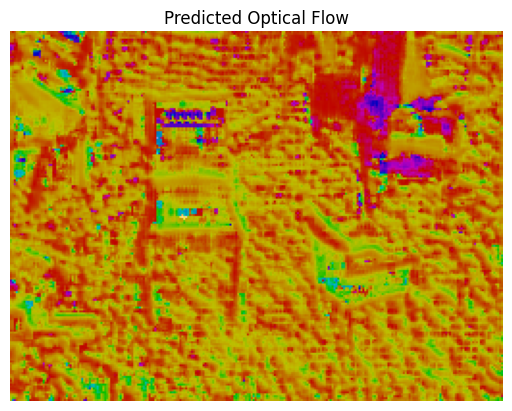

In [ ]:
""" FlowNet model written in TF2/Keras
    https://arxiv.org/pdf/1504.06852.pdf
"""

from typing import Dict, Tuple, Optional, Union
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

import utils_io as uio
import utils
from utils import flow_to_color
from config import CONFIG_FLOWNET, CONFIG_TRAINING
import matplotlib.pyplot as plt


class MalformedNetworkType(Exception):
    """The provided network type doesn't match one of 'simple' or 'correlation'."""


class FlowNet:
    """ FlowNetSimple model from the Computer Vision Group of Freiburg.
        https://lmb.informatik.uni-freiburg.de/
        https://lmb.informatik.uni-freiburg.de/Publications/2015/DFIB15/flownet.pdf
    """

    def __init__(self, config: Dict):
        self.config = config

        self.model = self._construct_network(config)

    def __getattr__(self, attr):
        """ Rather than potentially override any of the tf.keras.Model methods by subclassing and defining new methods,
            create a composition class with self.model:tf.keras.Model and allow attribute calls directly against self.model
        """
        return getattr(self.model, attr)

    @staticmethod
    def get_simple_model(config: Dict) -> tf.keras.Model:
        inputs = tf.keras.Input(shape=(384, 512, 6))

        conv_1 = tf.keras.layers.Conv2D(32, 7, strides=2, padding='same', activation='relu', name='conv1')(inputs)
        conv_2 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu', name='conv2')(conv_1)
        conv_3 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='same', activation='relu', name='conv3')(conv_2)

        predict_3 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_3')(conv_3)

        upconv_2 = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu', name='upconv_2')(conv_3)
        flow_3 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_3')(predict_3)
        concat_2 = tf.keras.layers.Concatenate(axis=-1, name='concat_2')([upconv_2, conv_2, flow_3])
        predict_2 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_2')(concat_2)

        upconv_1 = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu', name='upconv_1')(concat_2)
        flow_2 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_2')(predict_2)
        concat_1 = tf.keras.layers.Concatenate(axis=-1, name='concat_1')([upconv_1, conv_1, flow_2])
        predict_1 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_1')(concat_1)

        if config['training']:
            return tf.keras.Model(inputs=inputs, outputs=[predict_3, predict_2, predict_1])

        return tf.keras.Model(inputs=inputs, outputs=predict_1)


    def disable_training(self):
        """ After training is finished, run this method to have self.model predict a single array rather than a list of 6 arrays
        """
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=self.model.layers[-1].output)

    def enable_training(self):
        """ If you need to re-enable training, run this method to have self.model predict the list of 6 predictions
        """
        output_layers = [layer.output for layer in self.model.layers if 'predict' in layer.name]
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=output_layers)

    @staticmethod
    def get_corr_model(config: Dict) -> tf.keras.Model:
        raise NotImplementedError("The correlation model hasn't been implemented.")

    @staticmethod
    def _construct_network(config: Dict) -> tf.keras.Model:
        if config['architecture'] == 'simple':
            return FlowNet.get_simple_model(config)
        if config['architecture'] == 'corr':
            return FlowNet.get_corr_model(config)

        raise MalformedNetworkType(f"{config['architecture']}: {MalformedNetworkType.__doc__}")


class DataGenerator:
    """ Instantiate then call instance.next_train() to get a generator for training images/labels
            call instance.next_val() to get a generator for validation images/labels
    """

    def __init__(self,
                 network_type: str,
                 flo_normalization: Tuple[float, float],
                 root_path: Path,
                 batch_size: int,
                 validation_batch_size: int,
                 train_ratio: Union[float, int] = 1,
                 test_ratio: Union[float, int] = 0,
                 shuffle: bool = False,
                 augmentations: Optional[Dict] = None):
        self.network_type = network_type

        images = list(root_path.glob('*1.ppm'))
        self.train, self.val, self.test = utils.get_train_val_test(images, train_ratio, test_ratio, shuffle)
        self.batch_size = batch_size
        self.validation_batch_size = validation_batch_size
        self.replace = True
        self.flo_normalization = flo_normalization
        self.augmentations = augmentations
        
    def next_train(self):

        while True:
            images = np.random.choice(self.train, self.batch_size, replace=self.replace)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if not self.augmentations is None:
                img1, img2, label = self._augment(img1, img2, label)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def next_val(self):

        while True:
            images = np.random.choice(self.val, self.validation_batch_size, replace=False)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def _augment(self, img1, img2, label):
        # Augmentations are more awkward because of the Siamese architecture, I can't justify applying different color transforms to each image independently
        # I'm 100 certain there is a better way to do this as this is extremely inefficient with each call likely containing some portion of each other call.
        r = np.random.rand(len(self.augmentations))
        r_inc = 0  # This, with r, are used to randomly turn on/off augmentations so that not every augmentation is applied each time
        r_onoff = 2/5
        if 'brightness' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['brightness']
            def brt(x, idx): return tf.image.adjust_brightness(x, rdm[idx])
            img1 = tf.stack([brt(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([brt(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'multiplicative_colour' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size, 3) * (self.augmentations['multiplicative_colour'][1] -
                                                        self.augmentations['multiplicative_colour'][0]) + self.augmentations['multiplicative_colour'][0]

            def mc(x, idx): return x * rdm[idx]
            img1 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1
        if 'gamma' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['gamma'][1] - self.augmentations['gamma'][0]) + self.augmentations['gamma'][0]
            def gam(x, idx): return tf.image.adjust_gamma(x, gamma=rdm[idx])
            img1 = tf.stack([gam(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([gam(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'contrast' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['contrast'][1] - self.augmentations['contrast'][0]) + self.augmentations['contrast'][0]
            def cts(x, idx): return tf.image.adjust_contrast(x, contrast_factor=rdm[idx])
            img1 = tf.stack([cts(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([cts(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'gaussian_noise' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['gaussian_noise']
            def gau(x, idx): return x + tf.random.normal(x.shape, mean=0.0, stddev=rdm[idx], dtype=x.dtype)
            img1 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1

        return img1, img2, label


class EndPointError(tf.keras.losses.Loss):
    """ EndPointError is the Euclidean distance between the predicted flow vector and the ground truth averaged over all pixels.
        The resizing is required because the loss is calculated for each flow prediction which occur at different stride levels,
        resizing effectively averages at that scale.
    """

    def call(self, y_true, y_pred):
        return K.sqrt(K.sum(K.square(tf.image.resize(y_true, y_pred.shape[1:3]) - y_pred), axis=1, keepdims=True))
    

def load_images(image_name: str):
    """ Debug function to load the first image for visualization
    """
    root_path = Path(r'/Users/oscar/Downloads/FlyingChairs_release/data')
    flo_path = root_path / f'{image_name}_flow.flo'
    img1_path = root_path / f'{image_name}_img1.ppm'
    img2_path = root_path / f'{image_name}_img2.ppm'
    flo = uio.read(str(flo_path))
    img1 = uio.read(str(img1_path))
    img2 = uio.read(str(img2_path))
    img = np.expand_dims(np.concatenate([img1, img2], axis=-1), axis=0)

    # fig, ax = plt.subplots(ncols=2, nrows=2)
    # ax[0,0].imshow(img1)
    # ax[0,1].imshow(img2)
    # ax[1,0].imshow(flo[...,0])
    # ax[1,1].imshow(flo[...,1])
    # plt.show()

    return img, np.expand_dims(flo, axis=0)


def show_images(simple_images, label):
    """
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=2, nrows=2)
    ax[0, 0].imshow(simple_images[..., :3])
    ax[0, 1].imshow(simple_images[..., 3:])
    ax[1, 0].imshow(label[..., 0])
    ax[1, 1].imshow(label[..., 1])
    plt.show()


def main():
    config_network = deepcopy(CONFIG_FLOWNET)
    config_training = deepcopy(CONFIG_TRAINING)

    # On first run, populate the min, max scaling values for the flo dataset
    # min, max = utils.get_training_min_max(config_training['img_path'])

    flownet = FlowNet(config_network)

    loss = EndPointError()

    flownet.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=[loss, loss, loss, loss, loss, loss],
                    loss_weights=config_training['loss_weights'][::-1])

    data_generator = DataGenerator(config_network['architecture'],
                                   config_network['flo_normalization'],
                                   config_training['img_path'],
                                   config_training['batch_size'],
                                   config_training['validation_batch_size'],
                                   config_training['train_ratio'],
                                   config_training['test_ratio'],
                                   config_training['shuffle'],
                                   config_training['augmentations'])

    log_dir = f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_filepath = f"checkpoint/{datetime.now().strftime('%Y%m%d-%H%M%S')}.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                   save_weights_only=False,
                                                                   monitor='val_loss',
                                                                   mode='min',
                                                                   save_best_only=True)

    # if not config_training['pretrained_path'] is None:
    #     # flownet.model = tf.keras.models.load_model(config_training['pretrained_path'], custom_objects={'EndPointError': EndPointError})
    # flownet.fit(x=data_generator.next_train(),
    #             epochs=1,
    #             verbose=1,
    #             steps_per_epoch=200 // config_training['batch_size'],
    #             validation_data=data_generator.next_val(),
    #             validation_steps=4,
    #             validation_batch_size=config_training['validation_batch_size'],
    #             callbacks=[tensorboard_callback, model_checkpoint_callback],
    #             # use_multiprocessing=True
    #             )
    flownet.load_weights("/Users/oscar/Etudes/Ecole/PR/FlowNet_v1_TF2-master/src/flow.weights.h5")
    # flownet.save_weights('flow.weights.h5')
    # flownet.disable_training()

    # #
    # Temporary debugging and visualization
    # #
    img, flo = load_images(image_name="20000")
    # norm_img = utils.normalize_images(img)
    # predicted_flo = flownet.predict(norm_img)
    # predicted_flo = utils.denormalize_flo(predicted_flo, config_network['flo_normalization'])
    # predicted_flo = tf.image.resize(predicted_flo, (384, 512)).numpy()

    # import matplotlib.pyplot as plt
    # scale_min = np.min([np.min(flo), np.min(predicted_flo)])
    # scale_max = np.max([np.max(flo), np.max(predicted_flo)])
    # fig, ax = plt.subplots(ncols=2, nrows=3)
    # ax[0, 0].imshow(img[0, ..., :3])
    # ax[0, 1].imshow(img[0, ..., 3:])
    # ax[0, 0].set_ylabel('Input images')
    # ax[1, 0].imshow(flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[1, 1].imshow(flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[1, 0].set_ylabel('Ground truth flows')
    # ax[2, 0].imshow(predicted_flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[2, 1].imshow(predicted_flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[2, 0].set_ylabel('Predicted flows')
    # plt.show()

    # # print('stall')



# Predict
    pred_flow = flownet.predict(img)[0]   # (H, W, 2)

    # If your flow is normalized, denormalize first
    pred_flow = utils.denormalize_flo(
        pred_flow, config_network["flo_normalization"]
    )

    # Visualize
    flow_img = flow_to_color(pred_flow)

    import matplotlib.pyplot as plt
    plt.imshow(flow_img)
    plt.axis("off")
    plt.title("Predicted Optical Flow")
    plt.show()


    



if __name__ == "__main__":
    main()

In [ ]:
""" FlowNet model written in TF2/Keras
    https://arxiv.org/pdf/1504.06852.pdf
"""

from typing import Dict, Tuple, Optional, Union
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

import utils_io as uio
import utils
from utils import visualize_prediction
from config import CONFIG_FLOWNET, CONFIG_TRAINING
import matplotlib.pyplot as plt


class MalformedNetworkType(Exception):
    """The provided network type doesn't match one of 'simple' or 'correlation'."""


class FlowNet:
    """ FlowNetSimple model from the Computer Vision Group of Freiburg.
        https://lmb.informatik.uni-freiburg.de/
        https://lmb.informatik.uni-freiburg.de/Publications/2015/DFIB15/flownet.pdf
    """

    def __init__(self, config: Dict):
        self.config = config

        self.model = self._construct_network(config)

    def __getattr__(self, attr):
        """ Rather than potentially override any of the tf.keras.Model methods by subclassing and defining new methods,
            create a composition class with self.model:tf.keras.Model and allow attribute calls directly against self.model
        """
        return getattr(self.model, attr)

    @staticmethod
    def get_simple_model(config: Dict) -> tf.keras.Model:
        inputs = tf.keras.Input(shape=(384, 512, 6))

        conv_1 = tf.keras.layers.Conv2D(32, 7, strides=2, padding='same', activation='relu', name='conv1')(inputs)
        conv_2 = tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', activation='relu', name='conv2')(conv_1)
        conv_3 = tf.keras.layers.Conv2D(128, 5, strides=2, padding='same', activation='relu', name='conv3')(conv_2)

        predict_3 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_3')(conv_3)

        upconv_2 = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu', name='upconv_2')(conv_3)
        flow_3 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_3')(predict_3)
        concat_2 = tf.keras.layers.Concatenate(axis=-1, name='concat_2')([upconv_2, conv_2, flow_3])
        predict_2 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_2')(concat_2)

        upconv_1 = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu', name='upconv_1')(concat_2)
        flow_2 = tf.keras.layers.Conv2DTranspose(2, 4, strides=2, padding='same', activation='relu', name='flow_2')(predict_2)
        concat_1 = tf.keras.layers.Concatenate(axis=-1, name='concat_1')([upconv_1, conv_1, flow_2])
        predict_1 = tf.keras.layers.Conv2D(2, 3, strides=1, padding='same', activation=None, name='predict_1')(concat_1)

        if config['training']:
            return tf.keras.Model(inputs=inputs, outputs=[predict_3, predict_2, predict_1])

        return tf.keras.Model(inputs=inputs, outputs=predict_1)


    def disable_training(self):
        """ After training is finished, run this method to have self.model predict a single array rather than a list of 6 arrays
        """
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=self.model.layers[-1].output)

    def enable_training(self):
        """ If you need to re-enable training, run this method to have self.model predict the list of 6 predictions
        """
        output_layers = [layer.output for layer in self.model.layers if 'predict' in layer.name]
        self.model = tf.keras.Model(inputs=self.model.layers[0].input, outputs=output_layers)

    @staticmethod
    def get_corr_model(config: Dict) -> tf.keras.Model:
        raise NotImplementedError("The correlation model hasn't been implemented.")

    @staticmethod
    def _construct_network(config: Dict) -> tf.keras.Model:
        if config['architecture'] == 'simple':
            return FlowNet.get_simple_model(config)
        if config['architecture'] == 'corr':
            return FlowNet.get_corr_model(config)

        raise MalformedNetworkType(f"{config['architecture']}: {MalformedNetworkType.__doc__}")


class DataGenerator:
    """ Instantiate then call instance.next_train() to get a generator for training images/labels
            call instance.next_val() to get a generator for validation images/labels
    """

    def __init__(self,
                 network_type: str,
                 flo_normalization: Tuple[float, float],
                 root_path: Path,
                 batch_size: int,
                 validation_batch_size: int,
                 train_ratio: Union[float, int] = 1,
                 test_ratio: Union[float, int] = 0,
                 shuffle: bool = False,
                 augmentations: Optional[Dict] = None):
        self.network_type = network_type

        images = list(root_path.glob('*1.ppm'))
        self.train, self.val, self.test = utils.get_train_val_test(images, train_ratio, test_ratio, shuffle)
        self.batch_size = batch_size
        self.validation_batch_size = validation_batch_size
        self.replace = True
        self.flo_normalization = flo_normalization
        self.augmentations = augmentations
        
    def next_train(self):

        while True:
            images = np.random.choice(self.train, self.batch_size, replace=self.replace)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if not self.augmentations is None:
                img1, img2, label = self._augment(img1, img2, label)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def next_val(self):

        while True:
            images = np.random.choice(self.val, self.validation_batch_size, replace=False)
            img1 = [uio.read(str(img)) for img in images]
            img2 = [uio.read(str(img).replace('1.ppm', '2.ppm')) for img in images]
            label = [uio.read(str(img).replace('img1.ppm', 'flow.flo')) for img in images]

            img1 = utils.normalize_images(img1)
            img2 = utils.normalize_images(img2)
            label = utils.normalize_flo(label, self.flo_normalization)

            if self.network_type == 'simple':
                images = np.concatenate([img1, img2], axis=-1)
            elif self.network_type == 'correlation':
                raise NotImplementedError()
            else:
                raise MalformedNetworkType(f'{self.network_type}: {MalformedNetworkType.__doc__}')

            yield (images, np.array(label))

    def _augment(self, img1, img2, label):
        # Augmentations are more awkward because of the Siamese architecture, I can't justify applying different color transforms to each image independently
        # I'm 100 certain there is a better way to do this as this is extremely inefficient with each call likely containing some portion of each other call.
        r = np.random.rand(len(self.augmentations))
        r_inc = 0  # This, with r, are used to randomly turn on/off augmentations so that not every augmentation is applied each time
        r_onoff = 2/5
        if 'brightness' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['brightness']
            def brt(x, idx): return tf.image.adjust_brightness(x, rdm[idx])
            img1 = tf.stack([brt(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([brt(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'multiplicative_colour' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size, 3) * (self.augmentations['multiplicative_colour'][1] -
                                                        self.augmentations['multiplicative_colour'][0]) + self.augmentations['multiplicative_colour'][0]

            def mc(x, idx): return x * rdm[idx]
            img1 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([mc(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1
        if 'gamma' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['gamma'][1] - self.augmentations['gamma'][0]) + self.augmentations['gamma'][0]
            def gam(x, idx): return tf.image.adjust_gamma(x, gamma=rdm[idx])
            img1 = tf.stack([gam(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([gam(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'contrast' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * (self.augmentations['contrast'][1] - self.augmentations['contrast'][0]) + self.augmentations['contrast'][0]
            def cts(x, idx): return tf.image.adjust_contrast(x, contrast_factor=rdm[idx])
            img1 = tf.stack([cts(im, idx) for idx, im in enumerate(img1)], axis=0)
            img2 = tf.stack([cts(im, idx) for idx, im in enumerate(img2)], axis=0)
            r_inc += 1
        if 'gaussian_noise' in self.augmentations and r[r_inc] <= r_onoff:
            rdm = np.random.rand(self.batch_size) * self.augmentations['gaussian_noise']
            def gau(x, idx): return x + tf.random.normal(x.shape, mean=0.0, stddev=rdm[idx], dtype=x.dtype)
            img1 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img1)], axis=0), clip_value_min=0, clip_value_max=1)
            img2 = tf.clip_by_value(tf.stack([gau(im, idx) for idx, im in enumerate(img2)], axis=0), clip_value_min=0, clip_value_max=1)
            r_inc += 1

        return img1, img2, label


class EndPointError(tf.keras.losses.Loss):
    """ EndPointError is the Euclidean distance between the predicted flow vector and the ground truth averaged over all pixels.
        The resizing is required because the loss is calculated for each flow prediction which occur at different stride levels,
        resizing effectively averages at that scale.
    """

    def call(self, y_true, y_pred):
        return K.sqrt(K.sum(K.square(tf.image.resize(y_true, y_pred.shape[1:3]) - y_pred), axis=1, keepdims=True))
    

def load_images(image_name: str):
    """ Debug function to load the first image for visualization
    """
    root_path = Path(r'/Users/oscar/Downloads/FlyingChairs_release/data')
    flo_path = root_path / f'{image_name}_flow.flo'
    img1_path = root_path / f'{image_name}_img1.ppm'
    img2_path = root_path / f'{image_name}_img2.ppm'
    flo = uio.read(str(flo_path))
    img1 = uio.read(str(img1_path))
    img2 = uio.read(str(img2_path))
    img = np.expand_dims(np.concatenate([img1, img2], axis=-1), axis=0)

    # fig, ax = plt.subplots(ncols=2, nrows=2)
    # ax[0,0].imshow(img1)
    # ax[0,1].imshow(img2)
    # ax[1,0].imshow(flo[...,0])
    # ax[1,1].imshow(flo[...,1])
    # plt.show()

    return img, np.expand_dims(flo, axis=0)


def show_images(simple_images, label):
    """
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=2, nrows=2)
    ax[0, 0].imshow(simple_images[..., :3])
    ax[0, 1].imshow(simple_images[..., 3:])
    ax[1, 0].imshow(label[..., 0])
    ax[1, 1].imshow(label[..., 1])
    plt.show()


def main():
    config_network = deepcopy(CONFIG_FLOWNET)
    config_training = deepcopy(CONFIG_TRAINING)

    # On first run, populate the min, max scaling values for the flo dataset
    # min, max = utils.get_training_min_max(config_training['img_path'])

    flownet = FlowNet(config_network)

    loss = EndPointError()

    flownet.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=[loss, loss, loss, loss, loss, loss],
                    loss_weights=config_training['loss_weights'][::-1])

    data_generator = DataGenerator(config_network['architecture'],
                                   config_network['flo_normalization'],
                                   config_training['img_path'],
                                   config_training['batch_size'],
                                   config_training['validation_batch_size'],
                                   config_training['train_ratio'],
                                   config_training['test_ratio'],
                                   config_training['shuffle'],
                                   config_training['augmentations'])

    log_dir = f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    checkpoint_filepath = f"checkpoint/{datetime.now().strftime('%Y%m%d-%H%M%S')}.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                   save_weights_only=False,
                                                                   monitor='val_loss',
                                                                   mode='min',
                                                                   save_best_only=True)

    # if not config_training['pretrained_path'] is None:
    #     # flownet.model = tf.keras.models.load_model(config_training['pretrained_path'], custom_objects={'EndPointError': EndPointError})
    # flownet.fit(x=data_generator.next_train(),
    #             epochs=1,
    #             verbose=1,
    #             steps_per_epoch=200 // config_training['batch_size'],
    #             validation_data=data_generator.next_val(),
    #             validation_steps=4,
    #             validation_batch_size=config_training['validation_batch_size'],
    #             callbacks=[tensorboard_callback, model_checkpoint_callback],
    #             # use_multiprocessing=True
    #             )
    flownet.load_weights("/Users/oscar/Etudes/Ecole/PR/FlowNet_v1_TF2-master/src/flow.weights.h5")
    # flownet.save_weights('flow.weights.h5')
    # flownet.disable_training()
    flownet.load_weights(
        "/Users/oscar/Etudes/Ecole/PR/FlowNet_v1_TF2-master/src/flow.weights.h5"
    )

    # IMPORTANT: switch to inference mode (single output)
    flownet.disable_training()

    # Visualize one FlyingChairs sample (change ID if needed)
    visualize_prediction(
        flownet,
        image_name="00001",
        config=config_network
    )
    # #
    # Temporary debugging and visualization
    # #
    # img, flo = load_images(image_name="20000")
    # norm_img = utils.normalize_images(img)
    # predicted_flo = flownet.predict(norm_img)
    # predicted_flo = utils.denormalize_flo(predicted_flo, config_network['flo_normalization'])
    # predicted_flo = tf.image.resize(predicted_flo, (384, 512)).numpy()

    # import matplotlib.pyplot as plt
    # scale_min = np.min([np.min(flo), np.min(predicted_flo)])
    # scale_max = np.max([np.max(flo), np.max(predicted_flo)])
    # fig, ax = plt.subplots(ncols=2, nrows=3)
    # ax[0, 0].imshow(img[0, ..., :3])
    # ax[0, 1].imshow(img[0, ..., 3:])
    # ax[0, 0].set_ylabel('Input images')
    # ax[1, 0].imshow(flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[1, 1].imshow(flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[1, 0].set_ylabel('Ground truth flows')
    # ax[2, 0].imshow(predicted_flo[0, ..., 0], vmin=scale_min, vmax=scale_max)
    # ax[2, 1].imshow(predicted_flo[0, ..., 1], vmin=scale_min, vmax=scale_max)
    # ax[2, 0].set_ylabel('Predicted flows')
    # plt.show()

    # # print('stall')

    



if __name__ == "__main__":
    main()

ImportError: cannot import name 'visualize_prediction' from 'utils' (/Users/oscar/Etudes/Ecole/PR/FlowNet_v1_TF2-master/src/utils.py)